# Импорт библиотек!

In [1]:
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru
#!pip install --upgrade pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 684.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1dce08cd2e81714f8edc5fd1f97945cb6d668dfdd39a15043af4aae503877ed9
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [19]:
import numpy as np
import pandas as pd
#import cudf

from tqdm import tqdm
tqdm.pandas()
import os
import pymorphy2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
RANDOM_SEED = 42

# Загрузка данных

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Загрузка данных из файлов CSV
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_train.csv')
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

# Разведочный анализ данных

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60000 non-null  object
 1   class   60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [9]:
# Посмотрим на количество классов
train['class'].nunique()

50

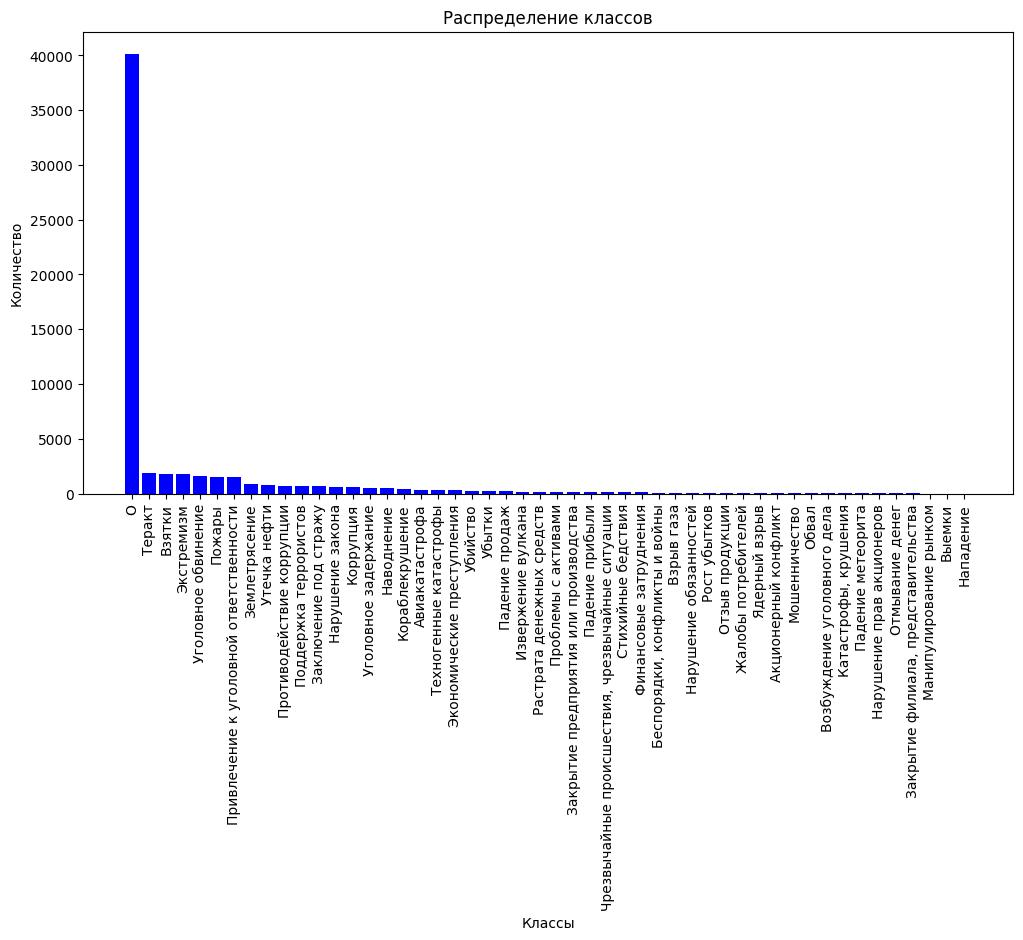

O                                                   40159
Теракт                                               1898
Взятки                                               1801
Экстремизм                                           1798
Уголовное обвинение                                  1634
Пожары                                               1510
Привлечение к уголовной ответственности              1475
Землетрясение                                         841
Утечка нефти                                          816
Противодействие коррупции                             707
Поддержка террористов                                 702
Заключение под стражу                                 694
Нарушение закона                                      636
Коррупция                                             599
Уголовное задержание                                  517
Наводнение                                            489
Кораблекрушение                                       378
Авиакатастрофа

In [11]:
# Подсчёт количества каждого класса
class_counts = train['class'].value_counts()

# Получение названий классов (индексов) и их количеств (значений)
classes = class_counts.index
counts = class_counts.values

# Создание фигуры и оси для графика
plt.figure(figsize=(12, 6))

# Построение графика
plt.bar(classes, counts, color='blue')

# Добавление названий осей и заголовка
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов')

# Поворот меток на оси X для лучшей читаемости
plt.xticks(rotation=90)

# Отображение графика
plt.show()

class_counts

Распределение неравномерное. Доминирование класса "О". Нам кажется, что при автоматической разметке, этот класс присваивался текстам, которые не смогли определить к какому-нибудь классу.
Эту неравномерность нужно будет учитывать при разделении на трейн и тест.

In [12]:
#посмотрим несколко примеров
train.sample(3)

text                class
37354  По мнению Крыжановского, она имеет "высокие ша...                    O
22251  Кони согласился с доводом, что иногда начальни...                    O
1282   Бывшего чиновника Минфина Юрия Чекина, подозре...  Уголовное обвинение

In [13]:
train['text'].iloc[44556]

'И этому есть весомые причины, ведь авиакатострофы хоть и случаются нечасто, зато о них пишут и говорят в разы больше, чем об автоавариях, железнодорожных и кораблекрушениях.'

In [14]:
train['class'].iloc[44556]

'Кораблекрушение'

Как видно из примера выше, разметка не совсем корректная. Но:
1. судя по всему тест размечен таким же образом, поэтому и корректировать классы будет не правильно;
2. количество размеченных новостей, почти 20 тысяч, поэтому перебирать их нецелесообразно с точки зрения затраченного времени.

### Лемматизирую текст

In [15]:
morph = pymorphy2.MorphAnalyzer()

In [16]:
def lem(x):
    x = list(x.split())
    x = [morph.parse(w)[0].normal_form for w in x]
    return x

In [ ]:
#train_cuda = cudf.DataFrame(train)

In [20]:
train['text_lem'] = train['text'].progress_apply(lem)

100%|██████████| 60000/60000 [07:39<00:00, 130.71it/s]


In [21]:
train.sample(3)

text  \
30429  Представитель Кремля уточнил, что открытым для...   
3025   Российский турист скончался, сорвавшись в проп...   
36251  Директор ФБК Иван Жданов объявил, что команда ...   

                                                  class  \
30429                                                 O   
3025   Чрезвычайные происшествия, чрезвычайные ситуации   
36251                                                 O   

                                                text_lem  
30429  [представитель, кремль, уточнил,, что, открыты...  
3025   [российский, турист, скончался,, сорваться, в,...  
36251  [директор, фбк, иван, жданов, объявил,, что, к...

In [ ]:
#%time
#train_cuda['text_lem'] = train['text'].apply(lem)

In [22]:
unique_words = {}
for i in tqdm(train.index):
    for j in set(train['text_lem'].loc[i]):
        if len(j) == 1:
            pass
        else:
            if j in unique_words.keys():
                unique_words[j] += 1
            else:
                unique_words[j] = 1

100%|██████████| 60000/60000 [00:03<00:00, 19400.92it/s]


In [23]:
sorted(list(unique_words.values()), reverse = True)[20000]

4

In [24]:
pop_words = []
for i in tqdm(unique_words.keys()):
    if unique_words[i] < 4:
        pass
    else:
        pop_words.append(i)

100%|██████████| 109544/109544 [00:00<00:00, 1328332.28it/s]


In [25]:
pop_words

['задача',
 'есть',
 'другой',
 'уверен:',
 'лично',
 'этом,',
 'вестись',
 'работа',
 'должный',
 'без',
 'продолжать',
 'обязать',
 'быть',
 'он',
 'по',
 'например,',
 'при',
 'или',
 'то',
 'служебный',
 'сотрудник',
 'политический',
 'поездка',
 'взгляды,',
 'информация',
 '"длить',
 'отмечать',
 'документ',
 'за',
 'граница',
 'гриф',
 'отдел',
 'анкета',
 '1-й',
 'допуск',
 'хранить',
 'специальный',
 'они',
 'сирийский',
 'принимать',
 'это',
 'пока',
 'меры",',
 'более',
 'безопасность',
 'но',
 'необходимо',
 'служба',
 'активный',
 'отметить',
 'он.',
 'тело',
 'днк',
 'найти',
 'мвд',
 'что',
 'мужчина',
 'совпасть',
 'на',
 'сообщили,',
 'дом',
 'брифинг',
 'журналистов.',
 'регулярный',
 'сообщить',
 'псак',
 'джена',
 'для',
 'белый',
 'пресс-секретарь',
 'среда',
 'обжаловать',
 'мы',
 'добавить',
 'приговор",',
 'произойти',
 'г.',
 'милицейский',
 'верхнекамский',
 'пожар',
 'автомобиле;',
 'район,',
 'ул.',
 'кирс,',
 'прокомментировать',
 'госдума',
 'арестовать',
 

In [26]:
def text_lem_set(x):
    y = []
    for w in x:
        if w in pop_words:
            y.append(w)
        else:
            pass
    return y


In [27]:
train['text_lem_set'] = train['text_lem'].progress_apply(lambda x: text_lem_set(x))

100%|██████████| 60000/60000 [04:02<00:00, 247.07it/s]


In [28]:
train.sample()

text class  \
1435  И все это подрывает доверие ко всей аграрной п...     O   

                                               text_lem  \
1435  [и, всё, это, подрывать, доверие, к, весь, агр...   

                                           text_lem_set  
1435  [всё, это, подрывать, доверие, весь, аграрный,...

In [29]:
train['text_lem_set_len'] = train['text_lem_set'].apply(lambda x: len(x))

<Axes: >

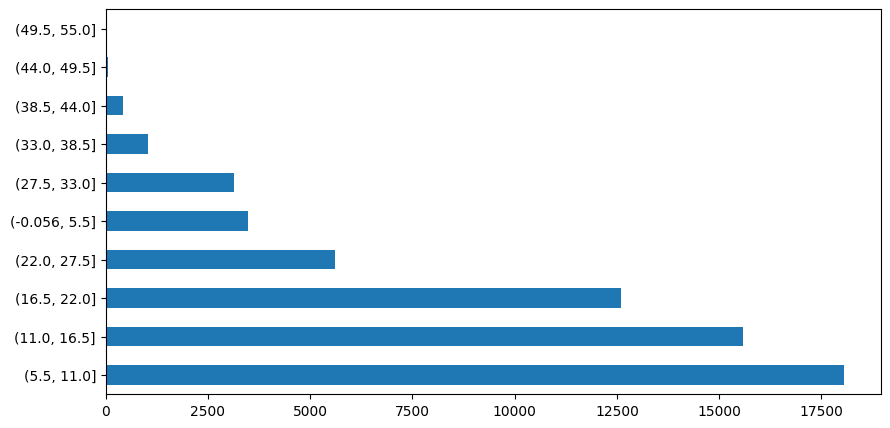

In [30]:
train['text_lem_set_len'].value_counts(bins = 10).plot(kind = 'barh',figsize = (10, 5))

In [31]:
len(pop_words)

20150

Количество уникальных слов 162 000 \
Лемматизированных уникальных слов 109 627

##  Попробую пойти по пути токенизации текста и моделей TensorFlow

In [32]:
# Максимальное количество слов
num_words = len(pop_words)

# Максимальная длина новости
max_news_len = 29

# Количество классов новостей
nb_classes = 50

In [33]:
train['class'] = train['class'].astype('category')
train['class_cat'] = train['class'].cat.codes
train.sample(3)

text class  \
1925   Очевидно, что пребывание разреженных протестую...     O   
59885  23 декабря директор новосибирского филиала СГК...     O   
1543   Бабанов же в качестве премьер-министра защищал...     O   

                                                text_lem  \
1925   [очевидно,, что, пребывание, разредить, протес...   
59885  [23, декабрь, директор, новосибирский, филиал,...   
1543   [бабанов, же, в, качество, премьер-министр, за...   

                                            text_lem_set  text_lem_set_len  \
1925   [очевидно,, что, пребывание, протестовать, на,...                34   
59885  [23, декабрь, директор, новосибирский, филиал,...                15   
1543   [же, качество, премьер-министр, защищать, пози...                20   

       class_cat  
1925           0  
59885          0  
1543           0

In [34]:
X = train['text_lem_set']
y = train['class']

In [35]:
y = pd.get_dummies(y)

In [36]:
y.sample()

O  Авиакатастрофа  Акционерный конфликт  Беспорядки, конфликты и войны  \
36840  0               0                     0                              0   

       Взрыв газа  Взятки  Возбуждение уголовного дела  Выемки  \
36840           0       1                            0       0   

       Жалобы потребителей  Заключение под стражу  ...  Убийство  Убытки  \
36840                    0                      0  ...         0       0   

       Уголовное задержание  Уголовное обвинение  Утечка нефти  \
36840                     0                    0             0   

       Финансовые затруднения  \
36840                       0   

       Чрезвычайные происшествия, чрезвычайные ситуации  \
36840                                                 0   

       Экономические преступления  Экстремизм  Ядерный взрыв  
36840                           0           0              0  

[1 rows x 50 columns]

In [37]:
# Разделяем на трейн и тест с учётом неравномернойти классов

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2)

In [38]:
X_train

55172    [президент, байден, не, отреагировать, на, пре...
51501    [экс-глава, ск, по, кчр, планировать, предъяви...
19478    [лесной, пожар, зафиксировать, ульяновский, об...
25205    [всё, это, быть, предмет, сегодняшний, очень, ...
48168    [да,, признать, сша, помогать, украина, деньга...
                               ...                        
34828    [посольство, китай, работать, обычный, большин...
1717     [тот, же, александр, зуев, рассказывает,, что,...
49739    [мы, парень, остаться, друзьями,, как, всё, но...
21971    [затем, быть, поместить, сизый, председатель, ...
53385    ["уголовный, производство, против, п., а., кон...
Name: text_lem_set, Length: 48000, dtype: object

Преобразую номера классов в кагориальную матрицу

In [39]:
y_train

O  Авиакатастрофа  Акционерный конфликт  Беспорядки, конфликты и войны  \
55172  1               0                     0                              0   
51501  0               0                     0                              0   
19478  0               0                     0                              0   
25205  1               0                     0                              0   
48168  1               0                     0                              0   
...   ..             ...                   ...                            ...   
34828  1               0                     0                              0   
1717   1               0                     0                              0   
49739  1               0                     0                              0   
21971  0               0                     0                              0   
53385  1               0                     0                              0   

       Взрыв газа  Взятки  Возбуждение уголовного дела  Выемки  \
55172           0       0                            0       0   
51501           0       0                            0       0   
19478           0       0                            0       0   
25205           0       0                            0       0   
48168           0       0                            0       0   
...           ...     ...                          ...     ...   
34828           0       0                            0       0   
1717            0       0                            0       0   
49739           0       0                            0       0   
21971           0       0                            0       0   
53385           0       0                            0       0   

       Жалобы потребителей  Заключение под стражу  ...  Убийство  Убытки  \
55172                    0                      0  ...         0       0   
51501                    0                      0  ...         0       0   
19478                    0                      0  ...         0       0   
25205                    0                      0  ...         0       0   
48168                    0                      0  ...         0       0   
...                    ...                    ...  ...       ...     ...   
34828                    0                      0  ...         0       0   
1717                     0                      0  ...         0       0   
49739                    0                      0  ...         0       0   
21971                    0                      1  ...         0       0   
53385                    0                      0  ...         0       0   

       Уголовное задержание  Уголовное обвинение  Утечка нефти  \
55172                     0                    0             0   
51501                     0                    1             0   
19478                     0                    0             0   
25205                     0                    0             0   
48168                     0                    0             0   
...                     ...                  ...           ...   
34828                     0                    0             0   
1717                      0                    0             0   
49739                     0                    0             0   
21971                     0                    0             0   
53385                     0                    0             0   

       Финансовые затруднения  \
55172                       0   
51501                       0   
19478                       0   
25205                       0   
48168                       0   
...                       ...   
34828                       0   
1717                        0   
49739                       0   
21971                       0   
53385                       0   

       Чрезвычайные происшествия, чрезвычайные ситуации  \
55172                                                 0   
51501               

In [40]:
y_train = np.array(y_train)

In [41]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [42]:
y_test = np.array(y_test)

In [43]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [44]:
tokenizer = Tokenizer(num_words=num_words)

In [45]:
tokenizer.fit_on_texts(train['text_lem_set'])

In [46]:
train_sequences = tokenizer.texts_to_sequences(X_train)

x_train = pad_sequences(train_sequences, maxlen=max_news_len)

test_sequences = tokenizer.texts_to_sequences(X_test)

x_test = pad_sequences(test_sequences, maxlen=max_news_len)

# Построение моделей

## Сверточная нейронная сеть

In [47]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(50, activation='softmax'))

In [48]:
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 32)            644800    
                                                                 
 conv1d (Conv1D)             (None, 25, 250)           40250     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
Total params: 723628 (2.76 MB)
Trainable params: 723628 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [56]:
# Путь к папке на Google Drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/model_weights'

# Проверка существования папки, и создание, если она не существует
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Папка 'model_weights' создана.")
else:
    print("Папка 'model_weights' уже существует.")


Папка 'model_weights' уже существует.


In [50]:
# Путь для сохранения модели на Google Drive
model_cnn_save_path = '/content/drive/MyDrive/Colab Notebooks/model_weights/best_model_cnn.h5'

# Создание callback для сохранения лучшей модели
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [51]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=128,
                            validation_split=0.01,
                            callbacks=[checkpoint_callback_cnn],
                            use_multiprocessing=True)

Epoch 1/5
371/372 [============================>.] - ETA: 0s - loss: 1.3613 - accuracy: 0.7074
Epoch 1: val_accuracy improved from -inf to 0.76042, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_cnn.h5
372/372 [==============================] - 17s 42ms/step - loss: 1.3610 - accuracy: 0.7074 - val_loss: 0.9930 - val_accuracy: 0.7604
Epoch 2/5
  1/372 [..............................] - ETA: 27s - loss: 0.7678 - accuracy: 0.8047

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


371/372 [============================>.] - ETA: 0s - loss: 0.6567 - accuracy: 0.8297
Epoch 2: val_accuracy improved from 0.76042 to 0.82083, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_cnn.h5
372/372 [==============================] - 18s 47ms/step - loss: 0.6566 - accuracy: 0.8297 - val_loss: 0.6545 - val_accuracy: 0.8208
Epoch 3/5
371/372 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8909
Epoch 3: val_accuracy improved from 0.82083 to 0.85417, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_cnn.h5
372/372 [==============================] - 16s 43ms/step - loss: 0.3998 - accuracy: 0.8910 - val_loss: 0.5645 - val_accuracy: 0.8542
Epoch 4/5
371/372 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.9224
Epoch 4: val_accuracy improved from 0.85417 to 0.87083, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_cnn.h5
372/372 [=====================

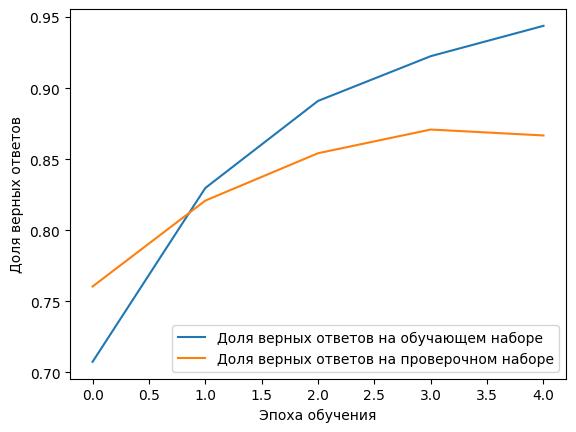

In [52]:
plt.plot(history_cnn.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [53]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(50, activation='softmax'))

In [54]:
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 32)            644800    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 50)                850       
                                                                 
Total params: 648786 (2.47 MB)
Trainable params: 648786 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# Путь для сохранения модели LSTM на Google Drive
model_lstm_save_path = '/content/drive/MyDrive/Colab Notebooks/model_weights/best_model_lstm.h5'

# Создание callback для сохранения лучшей модели LSTM
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           verbose=1)

In [58]:
history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=6,
                              batch_size=128,
                              validation_split=0.01,
                              callbacks=[checkpoint_callback_lstm],
                              use_multiprocessing=True)

Epoch 1/6
372/372 [==============================] - ETA: 0s - loss: 1.9541 - accuracy: 0.6638
Epoch 1: val_accuracy improved from -inf to 0.65417, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_lstm.h5
372/372 [==============================] - 17s 38ms/step - loss: 1.9541 - accuracy: 0.6638 - val_loss: 1.5466 - val_accuracy: 0.6542
Epoch 2/6
372/372 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.6815
Epoch 2: val_accuracy improved from 0.65417 to 0.69583, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_lstm.h5
372/372 [==============================] - 13s 34ms/step - loss: 1.2489 - accuracy: 0.6815 - val_loss: 1.2464 - val_accuracy: 0.6958
Epoch 3/6
371/372 [============================>.] - ETA: 0s - loss: 0.9958 - accuracy: 0.7419
Epoch 3: val_accuracy improved from 0.69583 to 0.70625, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_lstm.h5
372/372 [===========

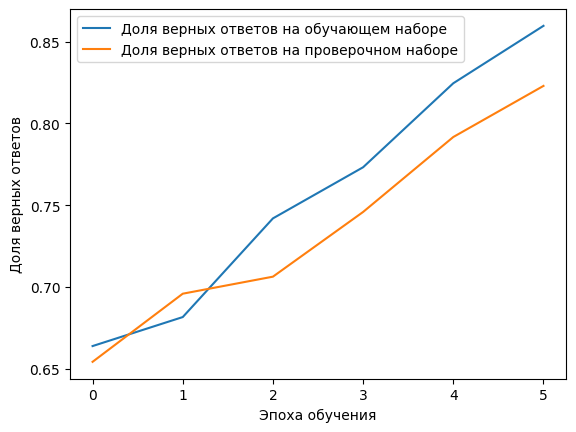

In [59]:
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [60]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(50, activation='softmax'))

In [61]:
model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 29, 32)            644800    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 50)                850       
                                                                 
Total params: 648050 (2.47 MB)
Trainable params: 648050 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# Путь для сохранения модели GRU на Google Drive
model_gru_save_path = '/content/drive/MyDrive/Colab Notebooks/model_weights/best_model_gru.h5'

# Создание callback для сохранения лучшей модели GRU
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [64]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=6,
                              batch_size=128,
                              validation_split=0.01,
                              callbacks=[checkpoint_callback_gru],
                              use_multiprocessing=True)

Epoch 1/6
372/372 [==============================] - ETA: 0s - loss: 1.8750 - accuracy: 0.6643
Epoch 1: val_accuracy improved from -inf to 0.66458, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_gru.h5
372/372 [==============================] - 21s 44ms/step - loss: 1.8750 - accuracy: 0.6643 - val_loss: 1.4436 - val_accuracy: 0.6646
Epoch 2/6
372/372 [==============================] - ETA: 0s - loss: 1.1709 - accuracy: 0.7210
Epoch 2: val_accuracy improved from 0.66458 to 0.75208, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_gru.h5
372/372 [==============================] - 16s 42ms/step - loss: 1.1709 - accuracy: 0.7210 - val_loss: 1.1239 - val_accuracy: 0.7521
Epoch 3/6
371/372 [============================>.] - ETA: 0s - loss: 0.8833 - accuracy: 0.7974
Epoch 3: val_accuracy improved from 0.75208 to 0.79167, saving model to /content/drive/MyDrive/Colab Notebooks/model_weights/best_model_gru.h5
372/372 [==============

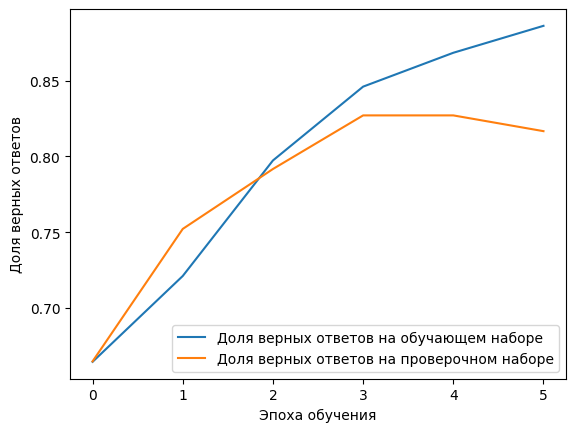

In [65]:
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть

In [66]:
model_cnn.load_weights(model_cnn_save_path)

In [67]:
model_cnn.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 2s 4ms/step - loss: 0.4873 - accuracy: 0.8783


[0.48725542426109314, 0.878250002861023]

### Сеть LSTM

In [68]:
model_lstm.load_weights(model_lstm_save_path)

In [69]:
model_lstm.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 2s 5ms/step - loss: 0.7046 - accuracy: 0.8332


[0.7046290636062622, 0.8332499861717224]

### Сеть GRU

In [70]:
model_gru.load_weights(model_gru_save_path)

In [71]:
model_gru.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 3s 7ms/step - loss: 0.6927 - accuracy: 0.8462


[0.6926541328430176, 0.8461666703224182]

# Предсказание на тестовых данных


In [72]:
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [73]:
test.sample(3)

text class
39962                   Юрий Самодуров: Каждый день, да.     O
28143  Мерой пресечения ей избрали запрет определенны...     O
35299  По данным ТАСС, в операции участвовали сотрудн...     O

In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   class   40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [75]:
test['text_lem'] = test['text'].progress_apply(lem)

100%|██████████| 40000/40000 [04:49<00:00, 138.40it/s]


In [76]:
test['text_lem_set'] = test['text_lem'].progress_apply(lambda x: text_lem_set(x))

100%|██████████| 40000/40000 [02:40<00:00, 248.82it/s]


In [77]:
test_2_sequences = tokenizer.texts_to_sequences(test['text_lem_set'])

x_test_2 = pad_sequences(test_2_sequences, maxlen=max_news_len)

In [78]:
y_test_pred_cnn = model_cnn.predict(x_test_2, verbose=1)
#y_test_pred_lstm = model_lstm.predict(x_test_2, verbose=1)
y_test_pred_gru = model_gru.predict(x_test_2, verbose=1)

1250/1250 [==============================] - 6s 4ms/step


In [79]:
test_pred = np.zeros(y_test_pred_cnn.shape)
for i in tqdm(range(y_test_pred_cnn.shape[0])):
    for j in range(y_test_pred_cnn.shape[1]):
        test_pred[i,j] = max(y_test_pred_cnn[i,j], y_test_pred_gru[i,j])

test_pred.shape


100%|██████████| 40000/40000 [00:04<00:00, 9780.95it/s] 


(40000, 50)

In [80]:
test_pred[1].max()

0.9869117140769958

In [81]:
test.sample(3)

text class  \
38925         Об этом в среду, 8 декабря, пишет Главком.     O   
1558   "По данным следствия, в первой половине текуще...     O   
26655  В конце 2019 года он был приговорен к семи год...     O   

                                                text_lem  \
38925  [о, это, в, среду,, 8, декабря,, писать, главк...   
1558   ["по, данные, следствия,, в, первый, половина,...   
26655  [в, конец, 2019, год, он, быть, приговорить, к...   

                                            text_lem_set  
38925                    [это, среду,, декабря,, писать]  
1558   ["по, данные, следствия,, первый, половина, те...  
26655  [конец, 2019, год, он, быть, приговорить, семь...

In [82]:
test_pred_class = []
for i in range(len(test_pred)):
    index, max_value = max(enumerate(test_pred[i]), key=lambda i_v: i_v[1])
    test_pred_class.append((index))

In [83]:
test_pred_class[0], len(test_pred_class)

(0, 40000)

In [84]:
test['class_cat'] = 0

In [85]:
y.columns[0]

'O'

In [86]:
for i in tqdm(test.index):
    test['class_cat'].iloc[i] = test_pred_class[i]

  0%|          | 0/40000 [00:00<?, ?it/s]<ipython-input-86-411a83d41df1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['class_cat'].iloc[i] = test_pred_class[i]
100%|██████████| 40000/40000 [00:16<00:00, 2356.85it/s]


In [87]:
test['class'] = test['class_cat'].apply(lambda x: y.columns[x])

In [88]:
test.sample(3)

text          class  \
37127  Президент объяснил свой побег из Афганистана с...              O   
10483  Индонезийские землетрясения не раз вызывали см...  Землетрясение   
31765  Адвокат Облонских Джордж Бенаур сообщил в элек...              O   

                                                text_lem  \
37127  [президент, объяснить, свой, побег, из, афгани...   
10483  [индонезийский, землетрясение, не, раз, вызыва...   
31765  [адвокат, облонской, джордж, бенаур, сообщить,...   

                                            text_lem_set  class_cat  
37127  [президент, объяснить, свой, побег, из, афгани...          0  
10483  [индонезийский, землетрясение, не, раз, вызыва...         12  
31765  [адвокат, джордж, сообщить, электронный, письм...          0

In [89]:
test['class'].value_counts()

O                                                   28115
Взятки                                               1460
Экстремизм                                           1318
Теракт                                               1169
Пожары                                               1105
Уголовное обвинение                                  1007
Привлечение к уголовной ответственности               808
Землетрясение                                         657
Нарушение закона                                      642
Утечка нефти                                          576
Уголовное задержание                                  368
Заключение под стражу                                 342
Поддержка террористов                                 320
Коррупция                                             296
Наводнение                                            293
Противодействие коррупции                             284
Кораблекрушение                                       261
Авиакатастрофа

In [91]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

In [92]:
sub.sample(5)

id class
39964  39964     O
7948    7948     O
34720  34720     O
8809    8809     O
35438  35438     O

In [93]:
submission = pd.DataFrame({'id':test.index})

In [94]:
submission['class'] = test['class']

In [95]:
submission.sample(3)

id                  class
15872  15872                 Теракт
30777  30777  Заключение под стражу
5504    5504                      O

In [96]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      40000 non-null  int64 
 1   class   40000 non-null  object
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [97]:
# Путь для сохранения файла submission.csv на Google Drive
submission_file_path = '/content/drive/MyDrive/Colab Notebooks/submission.csv'

# Сохранение DataFrame в CSV файл без индексов
submission.to_csv(submission_file_path, index=False)